# Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

## Importing libraries

In [1]:
from TCGame_Env import TicTacToe

from matplotlib import pyplot as plt

import collections
import numpy as np
import random
import pickle
import time
import math

## Defining env

In [2]:
env = TicTacToe(15)

## Defining functions

### To convert state array into a string to store it as keys in the dictionary

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x
def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

### To return valid (all possible actions) actions corresponding to a state

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.
def valid_actions(state):
    valid_Actions = []
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

### To add new Q-values to the Q-dictionary

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state_key = Q_state(state)
    
    valid_act = valid_actions(state)
    if state_key not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state_key][action]=0

### To initialise 'Q_dict' and 'States_track'

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
def reset_dicts():
    Q_dict = collections.defaultdict(dict)

    States_track = collections.defaultdict(dict)

    print('Q_dict size : {}'.format(len(Q_dict)))
    print('States_track size : {}'.format(len(States_track)))
    
    return Q_dict, States_track

### To initialise tracking states

In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    #select any 4 Q-values
    sample_q_values = [([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(0,1)),
                       ([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(2,3)),
                       ([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(4,5)),
                       ([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(6,7)),
                       ([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(8,9))]    
    for q_values in sample_q_values:
        state = Q_state(q_values[0])
        action = q_values[1]
        # this is an array which will have appended values of that state-action pair for 
        # every threshold value episode         
        States_track[state][action] = []   

### To save the obj as a pickle file

In [8]:
#Defining a function to save the obj as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### To save tracking states

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

## Epsilon-greedy strategy

In [10]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time, debug = False):
    max_epsilon = 1.0
    min_epsilon = 0.001
    epsilon = (min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time))
    
    if debug:
        print('Epsilon Value : {}'.format(epsilon))
        
    z = np.random.random()
        
    if z > epsilon:
        # Exploitation: this gets the action corresponding to max q-value of current state
        state_key = Q_state(state)
        action = max(Q_dict[state_key],key=Q_dict[state_key].get)
        if debug:
            print('Exploitation Action : {}'.format(action))
    else:
        # Exploration: randomly choosing and action
        action = random.choice(valid_actions(state)) 
        if debug:
            print('Exploration Action : {}'.format(action))
    
    return action

## Define hyperparameters

In [12]:
#Defining parameters for the experiment
EPISODES = 50000
threshold = 50
policy_threshold = 500
debug = False

# EPISODES = 5000000
# threshold = 1000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
# policy_threshold = 5000    #every these many episodes, the Q-dict will be updated
# debug = False

LR = 0.01                   #learning rate
GAMMA = 0.91

## Training

### Initialising dicts

In [13]:
Q_dict, States_track = reset_dicts()
initialise_tracking_states()

Q_dict size : 0
States_track size : 0


In [16]:
# Defining a function which will add new Q-values to the Q-dictionary. 
episode_position_dict = collections.defaultdict(dict)
def add_to_episode_action_position(episode):
    for position in range(9):
        episode_position_dict[episode][position]=0

### Q-update Loop

In [13]:
start_time = time.time()

for episode in range(EPISODES):    
    ##### Start writing your code from the next line
    
    add_to_episode_action_position(episode)
    
    if episode % policy_threshold == 0:
        print("Episode: {}".format(episode))
    
    # creating an instance of the class
    # this initialises the state back to some initial value which is required for every new episode
    env = TicTacToe(15)      
    
    # for the purpose of tracking reward
    initial_state = env.state    
    # note that we are starting as blank grid
    curr_state = env.state 
    
    if debug:
        print('\nBeginning Episode : {}'.format(episode + 1))
        print('Initial State : {}'.format(initial_state))
    
    add_to_dict(curr_state)
    
    total_reward = 0
    
    while len(valid_actions(curr_state)) > 0:    #the episode will run only for a few steps and not infinitely
      
        curr_action = epsilon_greedy(curr_state, episode, debug)
        
        episode_position_dict[episode][curr_action[0]]= episode_position_dict[episode][curr_action[0]] + 1
        
        next_state, reward, terminated = env.step(curr_state, curr_action) 
        
        add_to_dict(next_state)
                    
        curr_state_key = Q_state(curr_state)
            
        if terminated:
            next_state_q_value = 0
            
        else:
            next_state_key = Q_state(next_state)
            # this gets the action corresponding to max q-value of next state
            max_next = max(Q_dict[next_state_key],key=Q_dict[next_state_key].get) 
            next_state_q_value = Q_dict[next_state_key][max_next]
        
        # UPDATE RULE
        Q_dict[curr_state_key][curr_action] += LR * ((reward + (GAMMA*(next_state_q_value))) - 
                                                     Q_dict[curr_state_key][curr_action] )
        
        if debug:
            print('\nCurrent Action : {}'.format(curr_action))
            print('Next State : {}'.format(next_state))
            print('Reward : {}'.format(reward))
            print('Termination : {}'.format(terminated))
            print('Greedy Next Action : {}'.format(max_next))
            print('Next State Q value : {}'.format(next_state_q_value))
    
        #state(t) became state(t-1)
        curr_state = next_state      

        total_reward += reward
        
        if terminated:
            break
        
    if debug:   
        print('\nTotal Reward : {}\n'.format(total_reward))
    
    if ((episode+1) % threshold) == 0:   #every threshold episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every policy threshold episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')    
        
elapsed_time = time.time() - start_time
print("Episode: {}".format(EPISODES))
print('Elapsed Time : {}'.format(elapsed_time))
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

Episode: 0
Episode: 5000
Episode: 10000
Episode: 15000
Episode: 20000
Episode: 25000
Episode: 30000
Episode: 35000
Episode: 40000
Episode: 45000
Episode: 50000
Episode: 55000
Episode: 60000
Episode: 65000
Episode: 70000
Episode: 75000
Episode: 80000
Episode: 85000
Episode: 90000
Episode: 95000
Episode: 100000
Episode: 105000
Episode: 110000
Episode: 115000
Episode: 120000
Episode: 125000
Episode: 130000
Episode: 135000
Episode: 140000
Episode: 145000
Episode: 150000
Episode: 155000
Episode: 160000
Episode: 165000
Episode: 170000
Episode: 175000
Episode: 180000
Episode: 185000
Episode: 190000
Episode: 195000
Episode: 200000
Episode: 205000
Episode: 210000
Episode: 215000
Episode: 220000
Episode: 225000
Episode: 230000
Episode: 235000
Episode: 240000
Episode: 245000
Episode: 250000
Episode: 255000
Episode: 260000
Episode: 265000
Episode: 270000
Episode: 275000
Episode: 280000
Episode: 285000
Episode: 290000
Episode: 295000
Episode: 300000
Episode: 305000
Episode: 310000
Episode: 315000
E

Episode: 2480000
Episode: 2485000
Episode: 2490000
Episode: 2495000
Episode: 2500000
Episode: 2505000
Episode: 2510000
Episode: 2515000
Episode: 2520000
Episode: 2525000
Episode: 2530000
Episode: 2535000
Episode: 2540000
Episode: 2545000
Episode: 2550000
Episode: 2555000
Episode: 2560000
Episode: 2565000
Episode: 2570000
Episode: 2575000
Episode: 2580000
Episode: 2585000
Episode: 2590000
Episode: 2595000
Episode: 2600000
Episode: 2605000
Episode: 2610000
Episode: 2615000
Episode: 2620000
Episode: 2625000
Episode: 2630000
Episode: 2635000
Episode: 2640000
Episode: 2645000
Episode: 2650000
Episode: 2655000
Episode: 2660000
Episode: 2665000
Episode: 2670000
Episode: 2675000
Episode: 2680000
Episode: 2685000
Episode: 2690000
Episode: 2695000
Episode: 2700000
Episode: 2705000
Episode: 2710000
Episode: 2715000
Episode: 2720000
Episode: 2725000
Episode: 2730000
Episode: 2735000
Episode: 2740000
Episode: 2745000
Episode: 2750000
Episode: 2755000
Episode: 2760000
Episode: 2765000
Episode: 27700

Episode: 4890000
Episode: 4895000
Episode: 4900000
Episode: 4905000
Episode: 4910000
Episode: 4915000
Episode: 4920000
Episode: 4925000
Episode: 4930000
Episode: 4935000
Episode: 4940000
Episode: 4945000
Episode: 4950000
Episode: 4955000
Episode: 4960000
Episode: 4965000
Episode: 4970000
Episode: 4975000
Episode: 4980000
Episode: 4985000
Episode: 4990000
Episode: 4995000
Episode: 5000000
Elapsed Time : 9452.912454605103


## Checking Q_dict

In [15]:
with open('Policy.pkl', 'rb') as handle:
    Q_dict = pickle.load(handle)

print(len(Q_dict))

2261717


## Check States_track
(non-evaluative)

### Reading States_tracked file

In [16]:
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)  

In [17]:
for key, value in States_track.items():
    for k,v in value.items():
        print('State - Action - Value : {} - {} - {}'.format(key, k, len(v)))

State - Action - Value : x-x-x-x-x-x-x-x-x - (0, 1) - 5000
State - Action - Value : x-x-x-x-x-x-x-x-x - (2, 3) - 5000
State - Action - Value : x-x-x-x-x-x-x-x-x - (4, 5) - 5000
State - Action - Value : x-x-x-x-x-x-x-x-x - (6, 7) - 5000
State - Action - Value : x-x-x-x-x-x-x-x-x - (8, 9) - 5000


### Define state actions plot

In [18]:
def plot_state_actions(last_tracked_count = None):        
    plt.figure(0, figsize=(20,10))
    for state in States_track.keys():
        for idx, action in enumerate(States_track[state]):
            plt.subplot(math.ceil(len(States_track[state]) / 3), 3, idx + 1)
            if not last_tracked_count:
                last_tracked_count = len(States_track[state][action])
            xaxis = np.asarray(range(0, len(States_track[state][action][(-1*last_tracked_count):])))
            plt.title('state={} action={}'.format(state, action))
            plt.plot(xaxis,np.asarray(States_track[state][action][(-1*last_tracked_count):]))

    plt.show()

### Plotting state actions

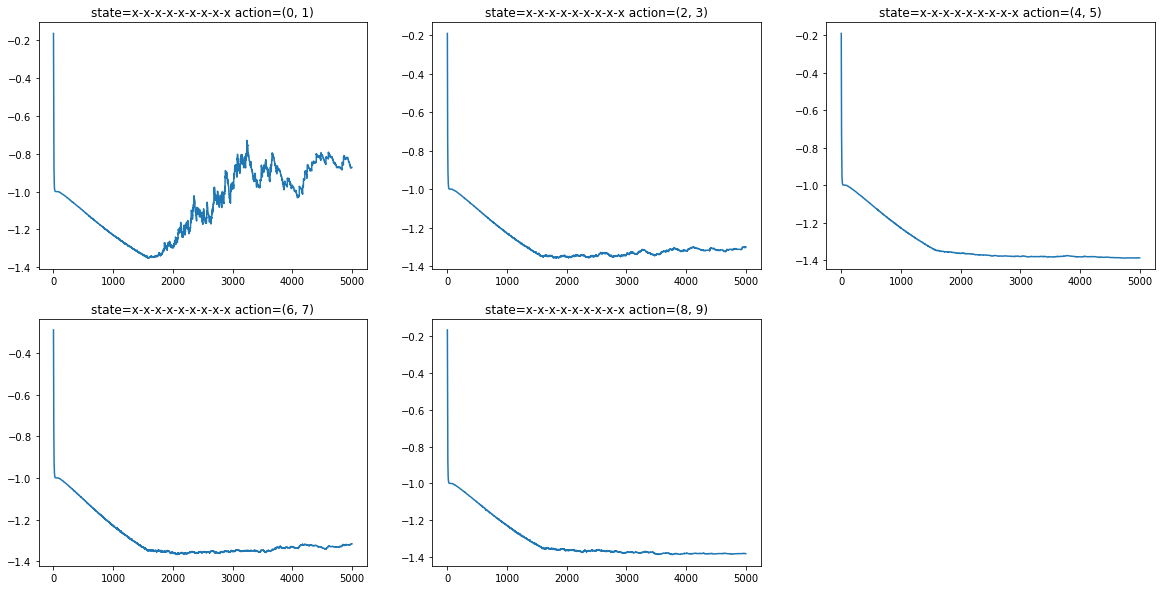

In [19]:
plot_state_actions()

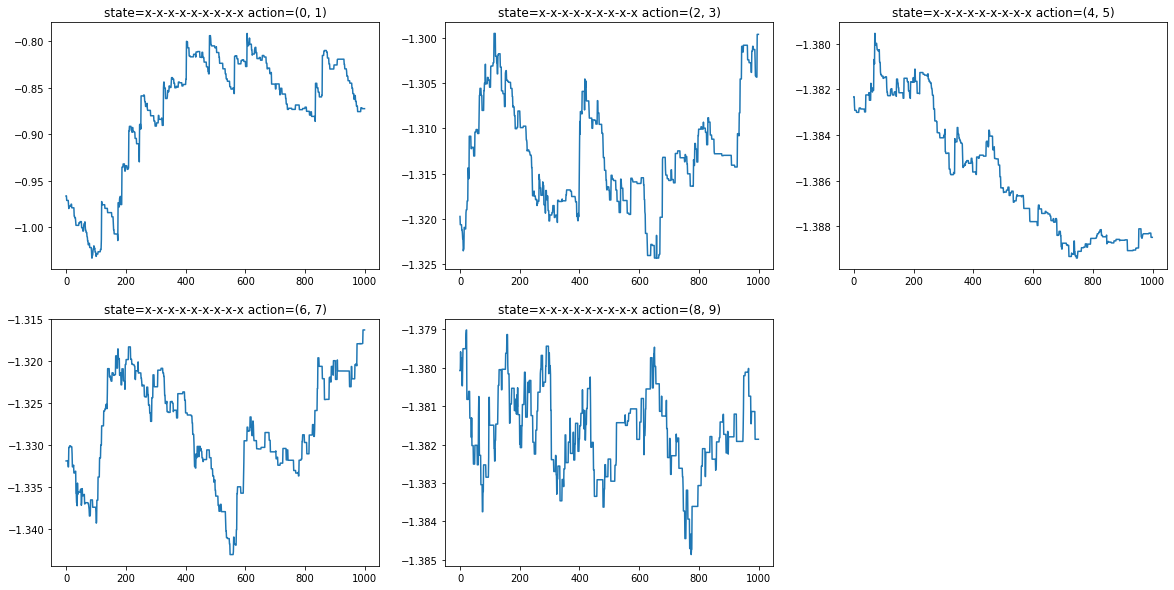

In [20]:
plot_state_actions(1000)

### Epsilon - decay check

In [21]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

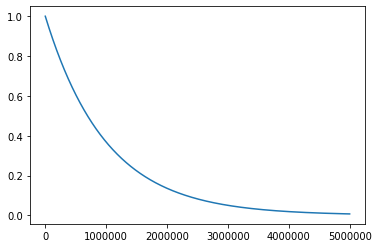

In [22]:
plt.plot(time, epsilon)
plt.show()